In [3]:
import pymc3 as pm
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

In [9]:
#import iris dataset using pandas

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris_dataset = pd.read_csv(url, names=column_names)
print(iris_dataset)

# Sepal Length and Petal Length as independent variables (x)
x = iris_dataset[['sepal_length', 'petal_length']].values
# Petal Width as dependent variable (y)
petal_width=iris_dataset['petal_width'].values
y=petal_width

# Mean-centering the independent variables
X_centered = x - x.mean(axis=0)

import pymc3 as pm
with pm.Model() as mlrModel:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(x.mean(axis=0), β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    data_mlrModel = pm.sample(2000, return_inferencedata=True)

     sepal_length  sepal_width  petal_length  petal_width         species
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]


In [10]:
#estimating values of slope and intercept
pm.summary(data_mlrModel)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,1.198,0.017,1.166,1.231,0.000,0.000,3721.0,2562.0,1.0
β[0],-0.080,0.042,-0.157,-0.002,0.001,0.001,2849.0,2294.0,1.0
β[1],0.449,0.019,0.412,0.484,0.000,0.000,2855.0,2453.0,1.0
ϵ,0.207,0.012,0.185,0.230,0.000,0.000,3681.0,2414.0,1.0
α,-0.021,0.185,-0.371,0.313,0.003,0.003,3008.0,2731.0,1.0


#Confounding Variable
- A variable that is associated with both the independent variable and the dependent variable and may lead to a misinterpretation of the relationship between them.

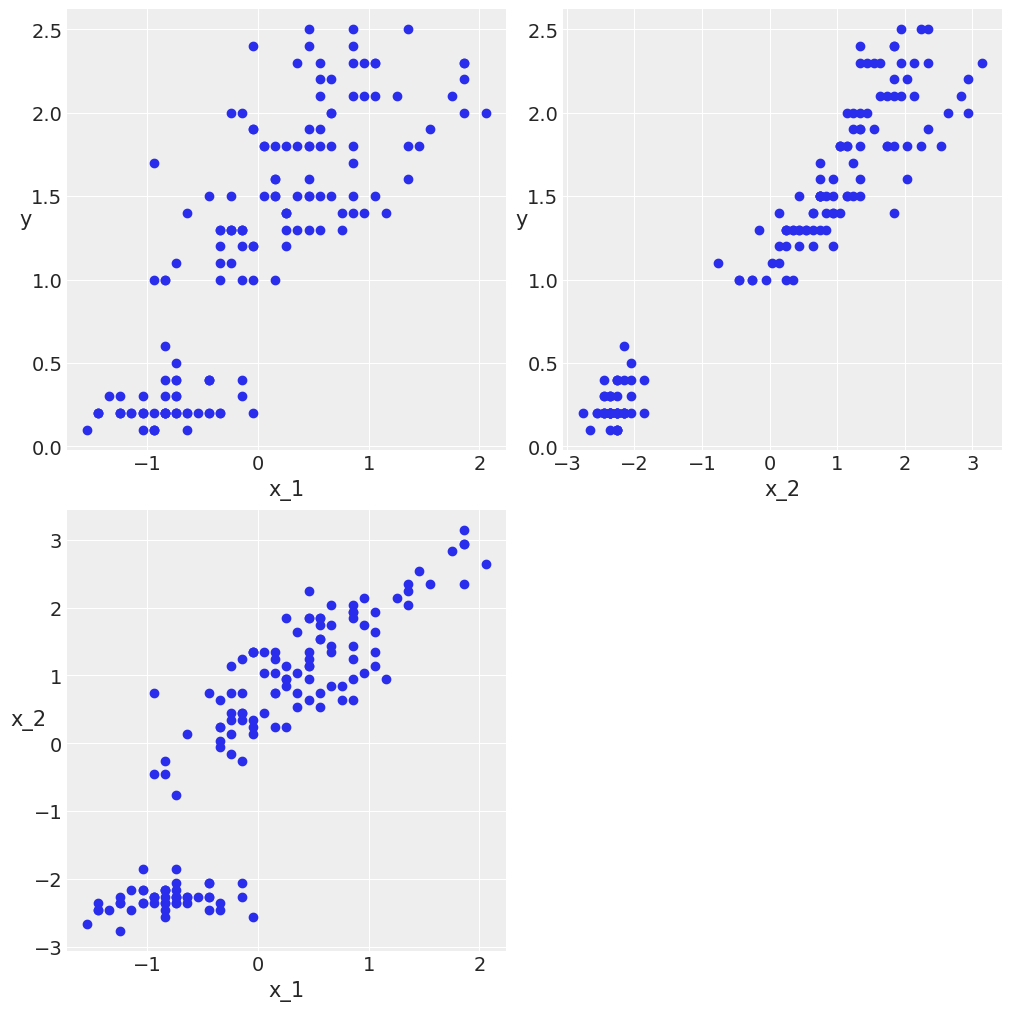

In [11]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)


Now build 3 related models for x1, x2 and x1x2, to find the confounding variable.

In [14]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * x[:, 0] + β2 * x[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x1x2 = pm.sample(3000, return_inferencedata=True)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * x[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x1 = pm.sample(3000, return_inferencedata=True)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * x[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x2 = pm.sample(3000, return_inferencedata=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

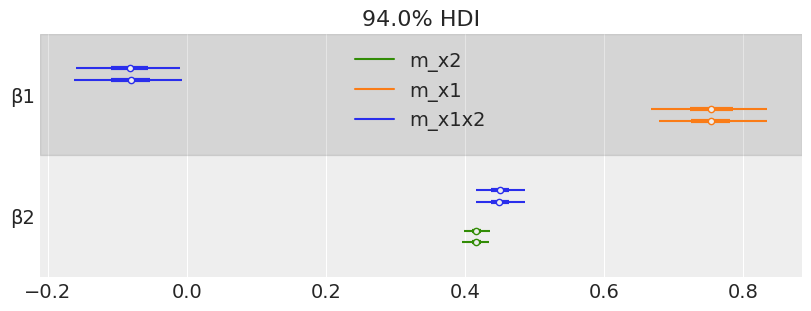

In [15]:
az.plot_forest([idata_x1x2, idata_x1, idata_x2],model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],combined=False, colors='cycle', figsize=(8, 3))

As we can see,  β1  for model m_x1x2 is around -0.1 less than zero, indicating an almost null contribution of the x1 variable i.e. Sepal Length to explain y. Also  β1  for model m_x1 is around 0.75. This is larger than for model m_x1x2. Thus the power of  x1  to predict  y  is reduced when we take into account  x2; the information in  x1  is redundant given  x2.
It can be concluded that:
- x2/petal length is confounding variable.
- x1/sepal length variable better explains y/petal width.

# Multicollinearity:


In [28]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(x, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_red = pm.sample(2000, target_accept=0.9, return_inferencedata=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

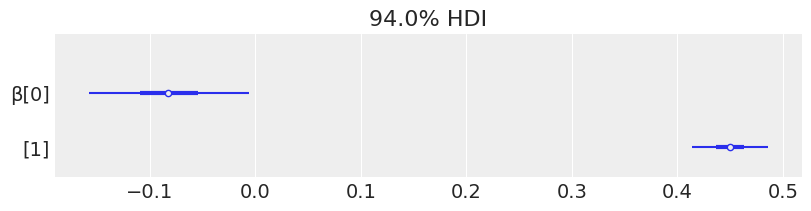

In [29]:
#plot the beta posterior to figure out multicollinearity
az.plot_forest(idata_red, var_names=['β'], combined=True, figsize=(8, 2))

<Axes: xlabel='β\n0', ylabel='β\n1'>

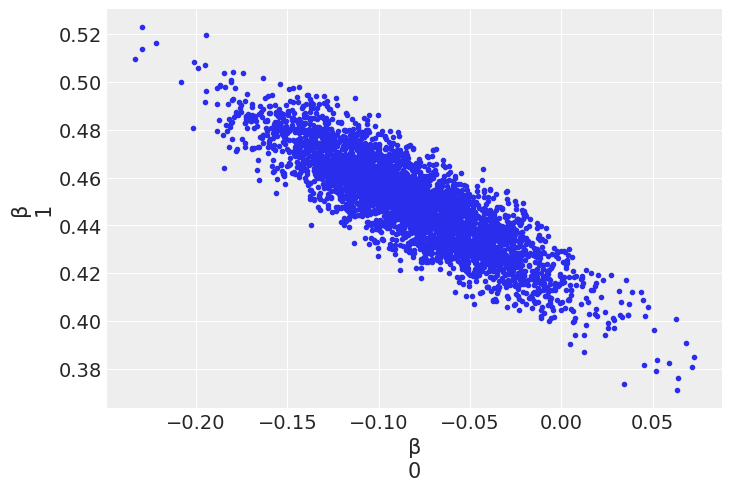

In [30]:
az.plot_pair(idata_red, var_names=['β'])

In [21]:
X = iris_dataset[['sepal_length','petal_length']]
# Method 2
# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       Variable       VIF
0  sepal_length  9.971283
1  petal_length  9.971283


So, VIF greater than 5 indicates high multicollinearity.
- To remove multicollinearity, one solution is to remove the redundant variable. As explained above, the redundant variable is x1/sepal length.


In [22]:
# creating this model by dropping the redundant variable x1
with pm.Model() as withoutFirstColumn:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * x[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    idata_x = pm.sample(3000, return_inferencedata=True)

In [23]:
pm.summary(idata_x)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.366,0.042,-0.443,-0.287,0.001,0.001,1849.0,1680.0,1.0
β2,0.416,0.010,0.398,0.436,0.000,0.000,1758.0,1939.0,1.0
ϵ,0.209,0.013,0.184,0.231,0.000,0.000,2785.0,2796.0,1.0
